In [326]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np 
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import math
sns.set_style('whitegrid')

In [327]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def reshape_train(data, timesteps, feature):
        return data.values.reshape(data.shape[0] , timesteps, feature)
    
def reshape_test(data, timesteps, feature):
        return data.values.reshape(data.shape[0] , timesteps*feature)
    
def plot_loss(data):
    sns.set_style('whitegrid')
    plt.figure(figsize=(16,4))
    plt.plot(data.history['loss'], color='darkred', linewidth=1.5, markersize=7, label='Train Loss')
    plt.plot(data.history['val_loss'], color='navy',linewidth=1.5,markersize=6, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation loss')
    legend = plt.legend(loc='upper right',prop={'size': 12})
    
def mape (obs, forc) :
    sum_total = 0
    for i in range(len(obs)):
        temp = abs((obs[i]-forc[i])/obs[i])
        sum_total = sum_total + temp
    mape_value = sum_total / len(obs)
    return mape_value

In [328]:
df = pd.read_csv(r'..\Data\2. BBCA.JK.csv')
df['Date'] = pd.to_datetime(df.Date)
df = df.drop(columns = 'Adj Close')
df = df[df.Volume != 0].reset_index(drop=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2019-01-02,26000,26225,26000,26200,7191200
1,2019-01-03,26000,26100,25575,25900,14471600
2,2019-01-04,25875,26025,25625,26025,10293000
3,2019-01-07,26325,26625,26225,26225,14687600
4,2019-01-08,26150,26600,26025,26200,13249500


In [329]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [330]:
dataset = pd.DataFrame({'Close':df.Close})
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scale = scaler.fit_transform(dataset)

In [331]:
#LSTM Parameter 
num_timesteps_in = 14
num_timesteps_out = 7
num_features_in = len(dataset.columns.tolist())
num_features_out= len(dataset.columns.tolist())
dataset_supervised = series_to_supervised(dataset_scale, num_timesteps_in, num_timesteps_out).reset_index(drop=True)

In [332]:
train = dataset_supervised.iloc[:-1]
test = dataset_supervised.iloc[-1:]

In [333]:
train_response

,var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6),var1(t+7),var1(t+8),var1(t+9)
0,0.126984,0.114286,0.190476,0.126984,0.203175,0.206349,0.196825,0.196825,0.238095,0.244444
1,0.114286,0.190476,0.126984,0.203175,0.206349,0.196825,0.196825,0.238095,0.244444,0.212698
2,0.190476,0.126984,0.203175,0.206349,0.196825,0.196825,0.238095,0.244444,0.212698,0.228571
3,0.126984,0.203175,0.206349,0.196825,0.196825,0.238095,0.244444,0.212698,0.228571,0.225397
4,0.203175,0.206349,0.196825,0.196825,0.238095,0.244444,0.212698,0.228571,0.225397,0.200000
...,...,...,...,...,...,...,...,...,...,...
200,0.771429,0.771429,0.752381,0.761905,0.736508,0.749206,0.749206,0.838095,1.000000,0.901587
201,0.771429,0.752381,0.761905,0.736508,0.749206,0.749206,0.838095,1.000000,0.901587,0.939683
202,0.752381,0.761905,0.736508,0.749206,0.749206,0.838095,1.000000,0.901587,0.939683,0.939683
203,0.761905,0.736508,0.749206,0.749206,0.838095,1.000000,0.901587,0.939683,0.939683,0.952381


In [334]:
train_response = train.loc[:,'var1(t)':]
train_predictor= train.drop(columns = train_response.columns.tolist())
# train_response = train_response.drop(columns = [col for col in train_response.columns if 'var4' not in col])

test_response = test.loc[:,'var1(t)':]
test_predictor= test.drop(columns = test_response.columns.tolist())
# test_response = test_response.drop(columns = [col for col in test_response.columns if 'var4' not in col])

train_X = reshape_train(train_predictor, num_timesteps_in, num_features_in)
train_y = reshape_test(train_response, num_timesteps_out,num_features_out)

test_X = reshape_train(test_predictor, num_timesteps_in, num_features_in)
test_y = reshape_test(test_response, num_timesteps_out, num_features_out)

In [335]:
num_timesteps_out*num_features_out

7

Train on 179 samples, validate on 45 samples
Epoch 1/500
179/179 [==============================] - 2s 9ms/step - loss: 0.3515 - val_loss: 0.5897
Epoch 2/500
179/179 [==============================] - 0s 942us/step - loss: 0.2701 - val_loss: 0.4261
Epoch 3/500
179/179 [==============================] - 0s 1ms/step - loss: 0.1885 - val_loss: 0.2894
Epoch 4/500
179/179 [==============================] - 0s 1ms/step - loss: 0.1440 - val_loss: 0.1677
Epoch 5/500
179/179 [==============================] - 0s 1ms/step - loss: 0.1065 - val_loss: 0.1096
Epoch 6/500
179/179 [==============================] - 0s 1ms/step - loss: 0.0913 - val_loss: 0.1159
Epoch 7/500
179/179 [==============================] - 0s 1ms/step - loss: 0.0934 - val_loss: 0.1149
Epoch 8/500
179/179 [==============================] - 0s 1ms/step - loss: 0.0848 - val_loss: 0.0946
Epoch 9/500
179/179 [==============================] - 0s 1ms/step - loss: 0.0766 - val_loss: 0.0800
Epoch 10/500
179/179 [======================

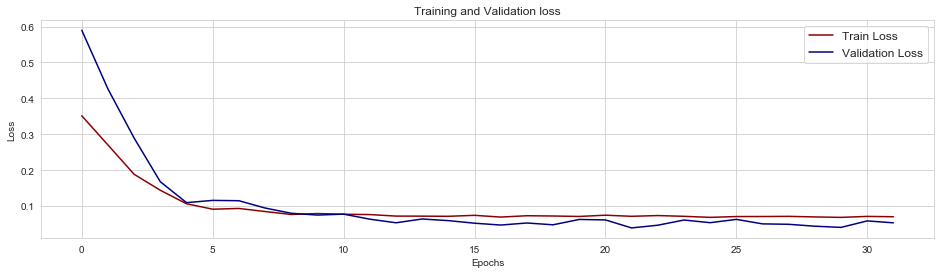

In [336]:
# design network
model = Sequential()
model.add(LSTM(50, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(num_timesteps_out*num_features_out))
model.compile(loss='mae', optimizer='adam')
# fit network
es = keras.callbacks.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min',  restore_best_weights=True)
history = model.fit(train_X, train_y, validation_split=0.2, epochs=500, batch_size=50, verbose=1, callbacks=[es], shuffle = False)

plot_loss(history)

In [337]:
# demonstrate prediction
pred = model.predict(test_X, verbose=0)

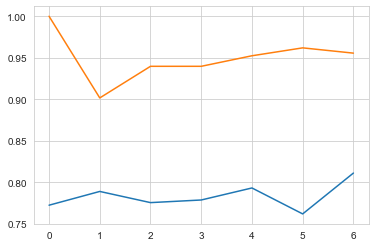

In [338]:
plt.plot(pred[0])
plt.plot(test_y[0])

In [339]:
mape(pred[0],test_y[0])

0.21395362427954012